In [1]:
from fastai.vision import *

In [2]:
model_name = "resampled_resnet34_1"
path = Path("/media/disk6tb/datasets/medical/rsna-intracranial-hemorrhage-detection/resampled")
df = pd.read_csv(path/'train_labels_as_resampled_1.csv')
df.head()

,fn,labels
0,ID_de92fa70f.png,intraparenchymal subdural any
1,ID_261b588fc.png,subdural any
2,ID_3d555d809.png,NaN
3,ID_d8d3490e2.png,subdural any
4,ID_84797e334.png,NaN


In [3]:
df.labels.fillna('', inplace=True)
df.head()

,fn,labels
0,ID_de92fa70f.png,intraparenchymal subdural any
1,ID_261b588fc.png,subdural any
2,ID_3d555d809.png,
3,ID_d8d3490e2.png,subdural any
4,ID_84797e334.png,


In [24]:
validation_set = None
with (path/'validation_set.pkl').open("rb") as fp:
    validation_set = pickle.load(fp)

In [27]:
list(validation_set)[0]

'ID_743e76a4c.png'

In [4]:
img = path/"256/train_png/ID_de92fa70f.png"
#im_arr = array(PIL.Image.open(img), dtype=np.uint16)
#im_arr.max()

In [5]:
def open_image_png16(fn:PathOrStr, cls:type=Image)->Image:
    a = array(PIL.Image.open(fn), dtype=np.uint16)
    a = a.astype('float32')
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    a = np.repeat(a, 3, axis=0)
    a = a / 65535.0
    return cls(torch.from_numpy(a))

class Png16ImageList(ImageList):
    def open(self, fn):
        return open_image_png16(fn)

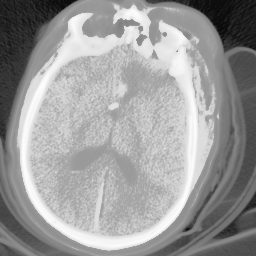

In [6]:
open_image_png16(img)

In [7]:
from fastai.data_block import _maybe_squeeze

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

ItemList.label_from_df = modified_label_from_df

In [8]:
sample_submission = pd.read_csv(path/'../stage_1_sample_submission.csv')
sample_submission['fn'] = sample_submission.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
sample_submission.head()
test_fns = sample_submission.fn.unique()

In [9]:
data = (Png16ImageList.from_csv(path, 'train_labels_as_resampled_1.csv', folder='256/train_png')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .add_test(str(path/'256/test_png') + "/" + test_fns)
        .databunch(bs=192))

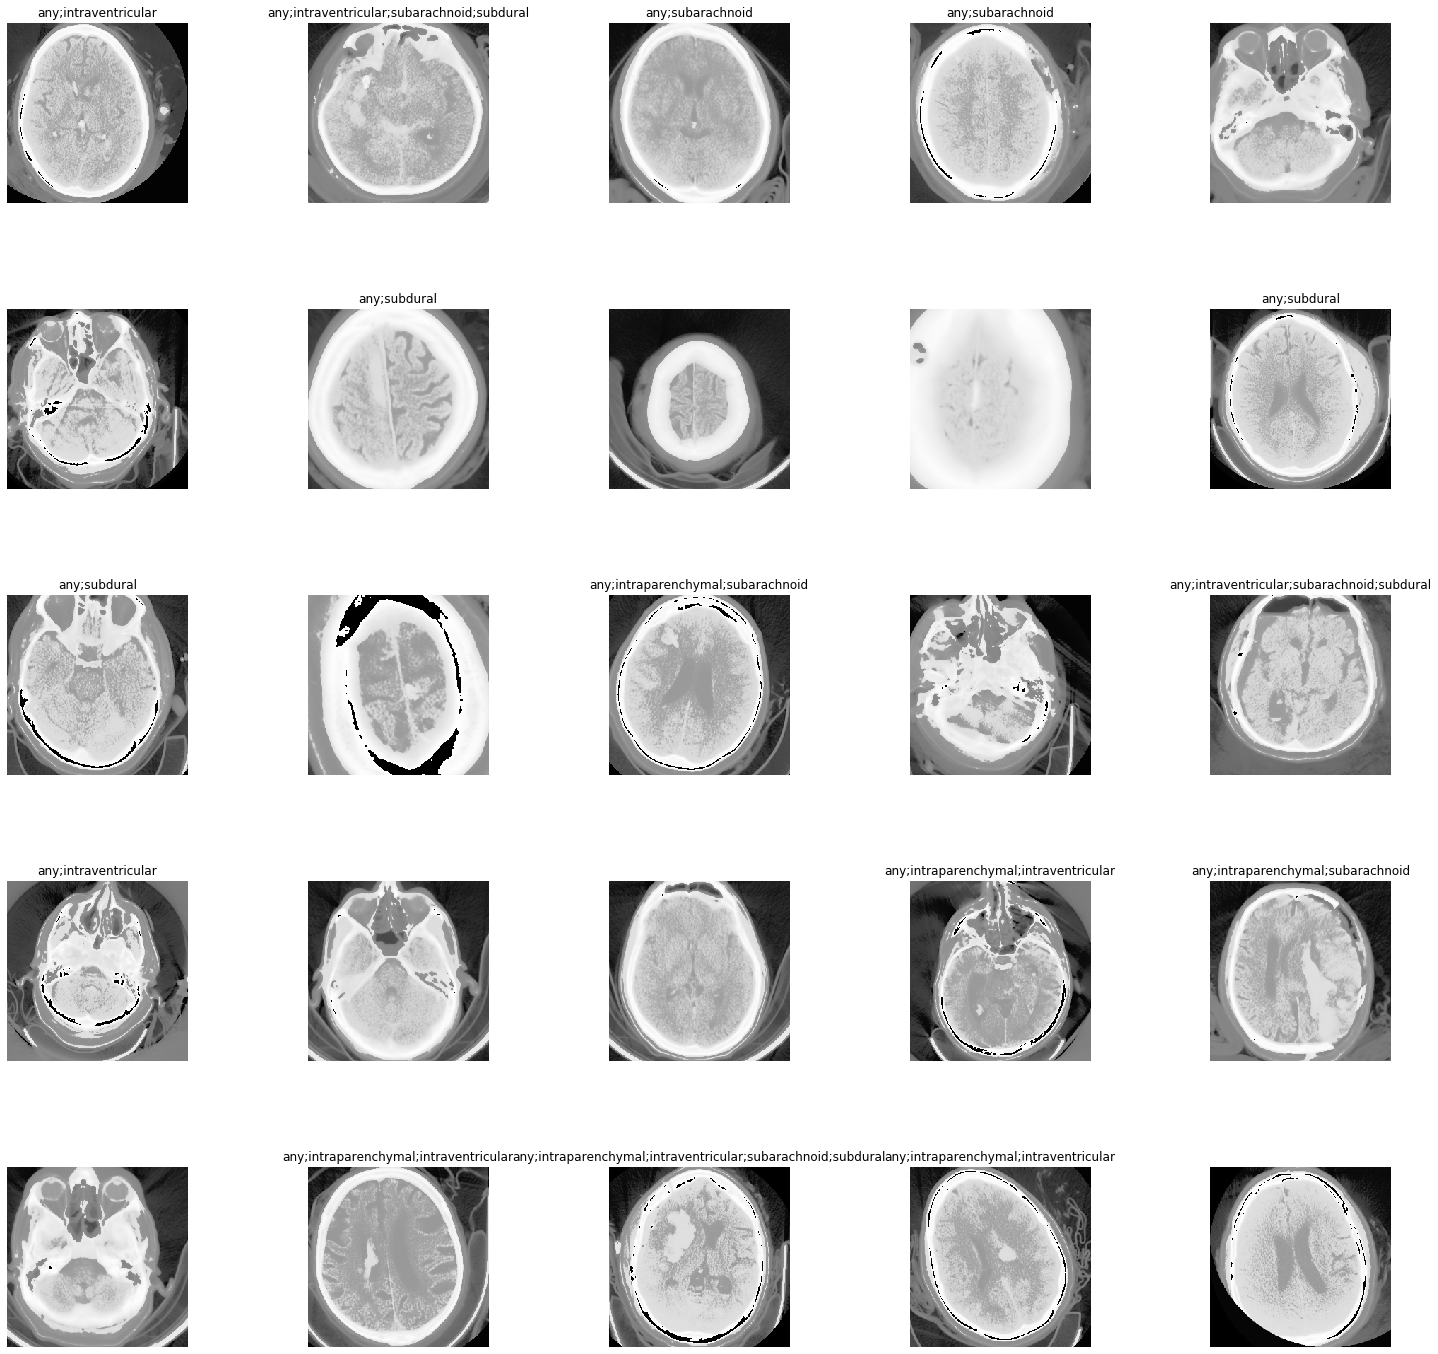

In [10]:
data.show_batch()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


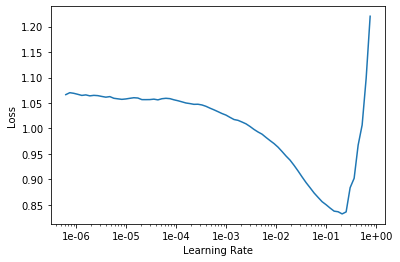

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy_thresh])
learn.opt_func = partial(optim.SGD, momentum=0.9)
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.314924,0.343621,0.845751,04:29
1,0.285372,0.330849,0.861174,04:29
2,0.253633,0.261773,0.893515,04:28
3,0.232565,0.237977,0.902887,04:28


In [13]:
#learn.fit_one_cycle(4, 2e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


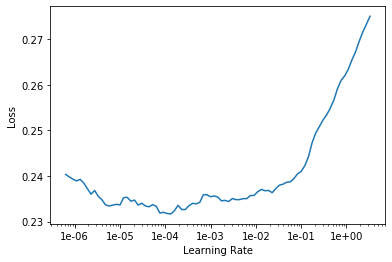

In [14]:
learn.save(f'{model_name}-phase-1')
learn.load(f'{model_name}-phase-1')
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, 1e-3)
learn.save(f'{model_name}-phase-2')

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.231668,0.236531,0.903459,04:56
1,0.229073,0.234025,0.904844,04:57
2,0.223945,0.232524,0.905314,04:56
3,0.223895,0.231728,0.905841,04:56


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


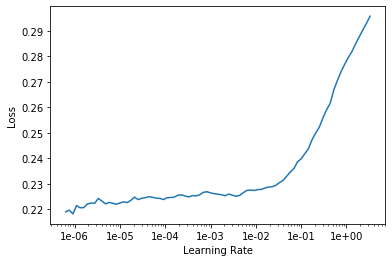

In [16]:
learn.load(f'{model_name}-phase-2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
#learn.fit_one_cycle(8, 5e-5)
learn.fit_one_cycle(cyc_len=8, max_lr=5e-04, wd=1e-4, div_factor=20., pct_start=0.8, moms=(0.95, 0.85))
learn.save(f'{model_name}-phase-3')

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.221624,0.231241,0.906293,05:58
1,0.224237,0.230588,0.906333,05:59
2,0.220480,0.229682,0.906694,05:58
3,0.219147,0.228198,0.907558,05:59
4,0.217321,0.228002,0.907466,06:00
5,0.216154,0.228258,0.907203,05:58
6,0.209845,0.225211,0.908755,05:59
7,0.212844,0.224121,0.909110,05:57


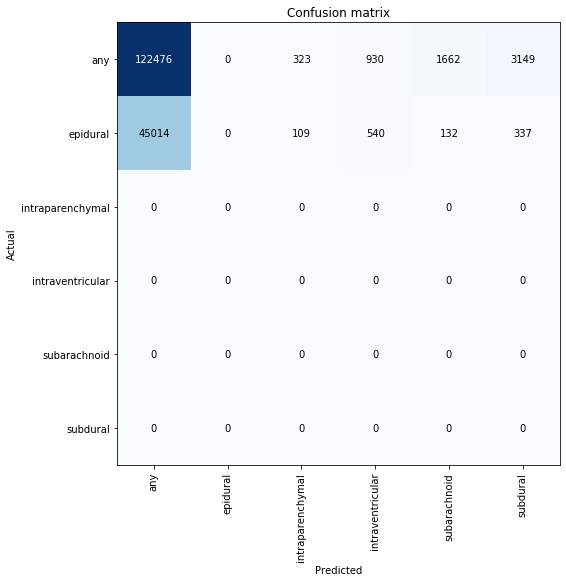

In [18]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y.long(), losses)
interp.plot_confusion_matrix(figsize=(8,8))

In [19]:
learn.load(f'{model_name}-phase-3')
preds, targs = learn.get_preds(DatasetType.Test)

In [20]:
ids = []
labels = []

for fn, pred in zip(test_fns, preds):
    for i, label in enumerate(data.train_ds.classes):
        ids.append(f"{fn.split('.')[0]}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [21]:
mkdir -p data/submissions

In [22]:
sub_name = f'{model_name}-resnet-resampled-18-1'
pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [23]:
#!kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f data/submissions/{sub_name}.csv.zip -m {sub_name}